---
# Tarea 1 Deep Learning
- Integrantes: Matias Aguilera, Jonas Oviedo y Natalia Romero
---

### Importar librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Función para calcular distribución de clases

In [2]:
def classes_distribution(arr):
    # Calculate the count of TRUE and FALSE
    count_true = np.count_nonzero(arr)
    count_false = arr.size - count_true

    # Calculate the percentage of TRUE and FALSE
    percent_true = (count_true / arr.size) * 100
    percent_false = (count_false / arr.size) * 100

    print(f"TRUE: {count_true} ({percent_true:.2f}%)")
    print(f"FALSE: {count_false} ({percent_false:.2f}%)")

### Implementación de Logistic Regression
La implementación se basa en el articulo de Medium "Logistic Regression From Scratch"



Kushal, K. (Fecha de publicación). Logistic Regression from Scratch. Medium. https://medium.com/@koushikkushal95/logistic-regression-from-scratch-dfb8527a4226

In [3]:
class LogisticRegression:
    def __init__(self, learning_rate=0.001, n_iters=1000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
        self.losses = []
         
    #Sigmoid method
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def compute_loss(self, y_true, y_pred):
        # binary cross entropy
        epsilon = 1e-9
        y1 = y_true * np.log(y_pred + epsilon)
        y2 = (1-y_true) * np.log(1 - y_pred + epsilon)
        return -np.mean(y1 + y2)

    def feed_forward(self,X):
        z = np.dot(X, self.weights) + self.bias
        A = self._sigmoid(z)
        return A

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Initialize parameters
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Gradient descent
        for _ in range(self.n_iters):
            A = self.feed_forward(X)
            loss = self.compute_loss(y, A)  # Compute current loss
            self.losses.append(loss)  # Record the loss

            dz = A - y  # Derivative of loss w.r.t. predictions
            dw = (1 / n_samples) * np.dot(X.T, dz)
            db = (1 / n_samples) * np.sum(dz)

            # Update parameters
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
            
    def predict(self, X):
        threshold = 0.5
        y_hat = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(y_hat)
        y_predicted_cls = np.array([1 if i > threshold else 0 for i in y_predicted])
        classes_distribution(y_predicted_cls)
        # Create an ID array
        ids = np.arange(len(y_predicted_cls))
        
        # Create a structured array
        arr = np.core.records.fromarrays([ids, y_predicted_cls], names='ID,Class')
        return arr
    
    def plot_loss(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.losses, label='Loss')
        plt.title('Loss vs. Iterations')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

### Train Dataset

In [4]:
train = np.genfromtxt('train_data.csv', delimiter=',', skip_header=1) 
X_train = train[:, :-1] 
X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
y_train = train[:, -1] 
classes_distribution(y_train)

TRUE: 1450 (39.40%)
FALSE: 2230 (60.60%)


### Test Dataset

In [5]:
test = np.genfromtxt('test_data.csv', delimiter=',', skip_header=1) 
X_test = test[:, :-1] 
X_test = (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)

### Entrenando el modelo

TRUE: 339 (36.81%)
FALSE: 582 (63.19%)


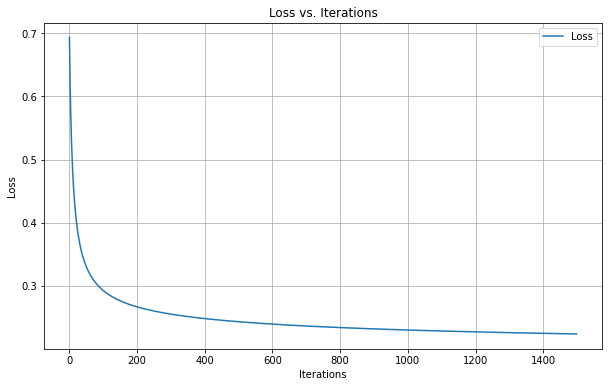

In [6]:
logistic_regression = LogisticRegression(learning_rate=0.09, n_iters=1500)
logistic_regression.fit(X_train, y_train)
predictions = logistic_regression.predict(X_test)
np.savetxt("submission.csv", predictions, delimiter=",", fmt='%d', header="ID,Class", comments='')
logistic_regression.plot_loss()

### Cálculo de métricas

In [7]:
def calculate_metrics(y_true, y_pred):
    # true positives, false positives, true negatives, and false negatives
    tp = np.sum((y_pred == 1) & (y_true == 1))
    tn = np.sum((y_pred == 0) & (y_true == 0))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))

    # metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall
    }

### K-Fold Cross Validation

In [8]:
def k_fold_split(X, y, k):
    n_samples = len(y)
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    fold_sizes = np.full(k, n_samples // k)
    fold_sizes[:n_samples % k] += 1
    current = 0
    folds = []
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        folds.append((indices[start:stop]))
        current = stop
    return folds

In [9]:
def cross_validation(X, y, k=5, learning_rate=0.09, n_iters=1500):
    folds = k_fold_split(X, y, k)
    scores = []
    for i in range(k):
        train_i = np.hstack([folds[j] for j in range(k) if j != i])
        test_i = folds[i]
        X_train, y_train = X[train_i], y[train_i]
        X_test, y_test = X[test_i], y[test_i]
        lr = LogisticRegression(learning_rate, n_iters)
        lr.fit(X_train, y_train)
        predictions = lr.predict(X_test)
        score = calculate_metrics(predictions['Class'],y_test)
        scores.append(score)
        print(f"Fold {i+1}, Score: {score}")
        lr.plot_loss()
        print("----------------")


TRUE: 271 (36.82%)
FALSE: 465 (63.18%)
Fold 1, Score: {'accuracy': 0.9402173913043478, 'precision': 0.9039145907473309, 'recall': 0.9372693726937269}


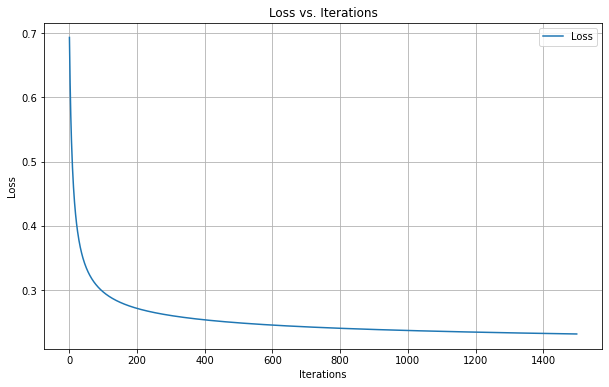

----------------
TRUE: 284 (38.59%)
FALSE: 452 (61.41%)
Fold 2, Score: {'accuracy': 0.9021739130434783, 'precision': 0.8441558441558441, 'recall': 0.9154929577464789}


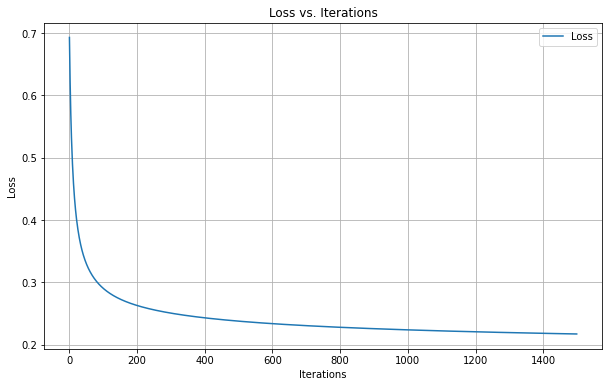

----------------
TRUE: 261 (35.46%)
FALSE: 475 (64.54%)
Fold 3, Score: {'accuracy': 0.90625, 'precision': 0.8453237410071942, 'recall': 0.9003831417624522}


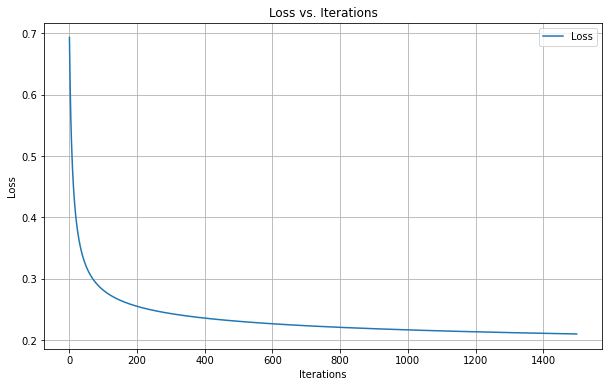

----------------
TRUE: 269 (36.55%)
FALSE: 467 (63.45%)
Fold 4, Score: {'accuracy': 0.9239130434782609, 'precision': 0.8736842105263158, 'recall': 0.9256505576208178}


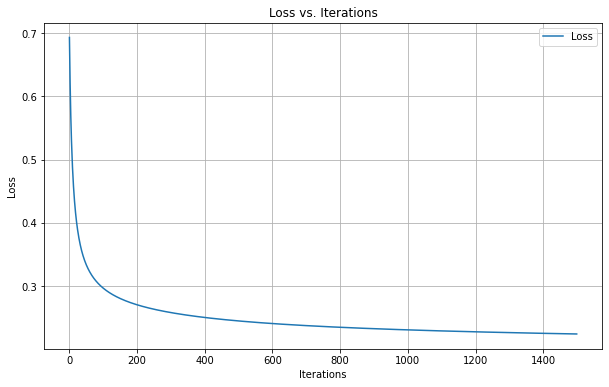

----------------
TRUE: 284 (38.59%)
FALSE: 452 (61.41%)
Fold 5, Score: {'accuracy': 0.9157608695652174, 'precision': 0.87248322147651, 'recall': 0.9154929577464789}


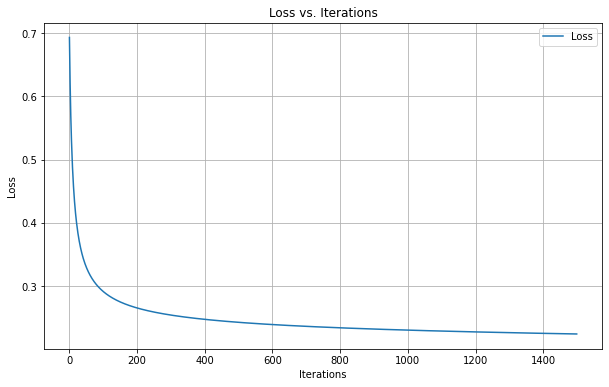

----------------


In [10]:
cross_validation(X_train,y_train)